In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
%matplotlib inline
import re 
import math
import time

In [11]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
# import spacy
# # Need to load the large model to get the vectors
# import en_core_web_sm
# nlp = en_core_web_sm.load()

In [70]:
RANDOM_SEED = 123
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
import os
import pandas as pd

# read the text file and add the column names
read_file = pd.read_csv(r"booksummaries.txt", sep='	', header=None)
read_file.columns = ['ID', 'm number', 'book name', 'author name', 'date', 'label', 'summary']

# clean data
read_file['label'] = read_file['label'].str.replace(r'/m/\S*\s', '')
read_file['label'] = read_file['label'].str.replace(r'{', '')
read_file['label'] = read_file['label'].str.replace(r'}', '')
read_file['label'] = read_file['label'].str.replace(r'}', '')
read_file['label'] = read_file['label'].str.replace(r'\\u00e0\s+clef', '')

# select columns
new_file = read_file.loc[:, ['book name', 'label', 'summary']]

#delete the columns with no labels
new_file.dropna(axis = 0, how = 'any', inplace = True)
new_file = new_file.iloc[:, [0, 2, 1]]

new_file = new_file.reset_index(drop=True)

#output data as csv
new_file.to_csv(r'./booksummries.csv', index=False)


In [14]:
new_file.head()

,book name,summary,label
0,Animal Farm,"Old Major, the old boar on the Manor Farm, ca...","""""Roman "", """"Satire"", """"Children's literature""..."
1,A Clockwork Orange,"Alex, a teenager living in near-future Englan...","""""Science Fiction"", """"Novella"", """"Speculative ..."
2,The Plague,The text of The Plague is divided into five p...,"""""Existentialism"", """"Fiction"", """"Absurdist fic..."
3,A Fire Upon the Deep,The novel posits that space around the Milky ...,"""""Hard science fiction"", """"Science Fiction"", ""..."
4,All Quiet on the Western Front,"The book tells the story of Paul Bäumer, a Ge...","""""War novel"", """"Roman """


In [15]:
def text_process(label_list):
    has_fiction = False
    has_spec_fiction = False
    has_novel = False
    has_spec_novel = False
    for i in range(len(label_list)):
        if 'novel' in label_list[i].lower():
            if 'novel' == label_list[i].lower():
                has_novel = True
            else:
                has_spec_novel = True
        if 'fiction' in label_list[i].lower():
            if 'fiction' == label_list[i].lower():
                has_fiction = True
            else:
                has_spec_fiction = True
        
    if has_spec_fiction and has_spec_novel:
        if has_fiction:
            label_list.remove('fiction')
        if has_novel:
            label_list.remove('novel')
    elif has_spec_fiction:
        if has_fiction:
            label_list.remove('fiction')
        if has_novel:
            label_list.remove('novel')
    elif has_spec_novel:
        if has_fiction:
            label_list.remove('fiction')
        if has_novel:
            label_list.remove('novel')
    elif has_fiction and has_novel:
        label_list.remove('fiction')
    return label_list

In [16]:
import re
for index in range(len(new_file['label'])):
    label = new_file['label'][index].replace('"', ''). lower()
    label_list = re.split(', ', label)  
    label_list = text_process(label_list)
    new_file.xs(index)['label']= label_list

In [17]:
#output data as csv
new_file.to_csv(r'./booksummries.csv', index=False)


In [18]:
new_file.tail()

,book name,summary,label
12836,The Third Lynx,The story starts with former government agent...,[science fiction]
12837,Remote Control,The series follows the character of Nick Ston...,"[thriller, fiction, suspense]"
12838,Transfer of Power,The reader first meets Rapp while he is doing...,"[thriller, fiction]"
12839,Decoded,The book follows very rough chronological ord...,[autobiography]
12840,Poor Folk,Makar Devushkin and Varvara Dobroselova are s...,"[epistolary novel, speculative fiction]"


In [32]:
categories = list(new_file['label'].values)
all_labels = [ word for labels in categories for word in labels]
counts = Counter(all_labels)
# for i in categories:
#     counts.append((i, new_file['label'][i].sum()))
df_stats = pd.DataFrame(counts.items(), columns=['labels', '#books'])
df_stats = df_stats.sort_values(by = '#books', ascending = False)
df_stats

,labels,#books
3,speculative fiction,4314
4,science fiction,2870
10,fantasy,2413
2,children's literature,2122
33,novel,1581
...,...,...
187,fable,1
188,bangsian fantasy,1
189,space western,1
194,fantastique,1


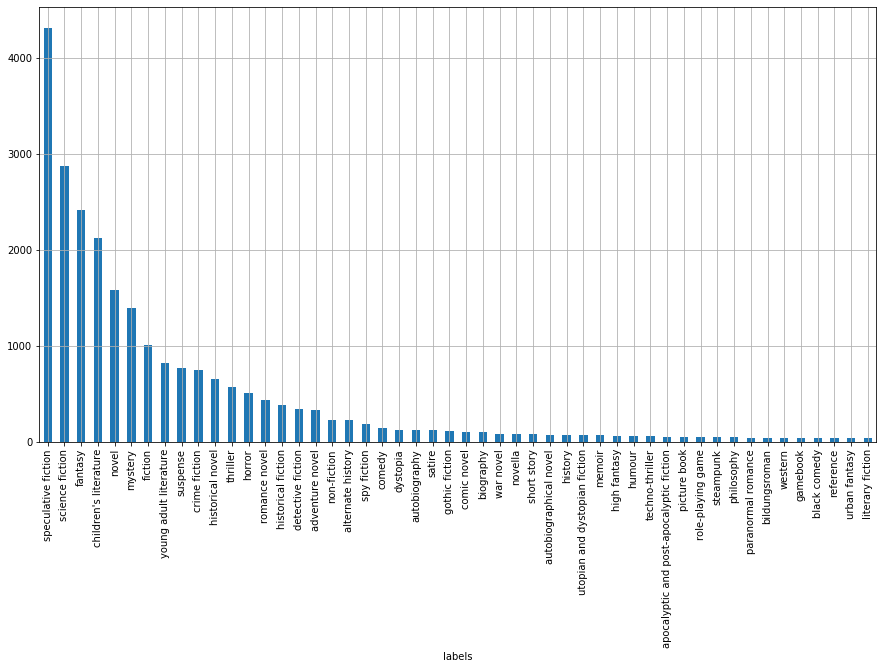

In [31]:
df_stats.iloc[:50, :].plot(x='labels', y='#books', kind='bar', legend=False, grid=True, figsize=(15, 8))

  ## Encoding the Labels##




In [33]:
label_list = []
for index in range(len(new_file['label'])):
    object_label = new_file['label'][index]
    for l in object_label:
        if l not in label_list:
            label_list.append(l)

In [34]:
len(label_list)

227

In [35]:
one_hot = pd.DataFrame(np.zeros((12841, 227)), columns=label_list).astype(int)

In [36]:
for index in range(len(new_file['label'])):
    object_label = new_file['label'][index]
    for l in object_label:
        one_hot[l][index] = 1

In [37]:
one_hot

,roman,satire,children's literature,speculative fiction,science fiction,novella,utopian and dystopian fiction,existentialism,absurdist fiction,hard science fiction,...,encyclopedia,mashup,biopunk,popular culture,neuroscience,new york times best seller list,epic science fiction and fantasy,alien invasion,prose,pastiche
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12836,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12838,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12839,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Split the words##

In [38]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


def words_process(new_file):
    book_summaries = new_file['summary']
    summary_list = [summary for summary in book_summaries]
    summary_num = len(summary_list)
    #summaries = ''.join(summary_list)
    print("the total number of books: {}\n".format(summary_num))
    
    all_docs = []

    for doc in summary_list:
        # Tokenize the string into words
        tokens = word_tokenize(doc)
        # Remove non-alphabetic tokens, such as punctuation
        words = [word.lower() for word in tokens if word.isalpha()]
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if not word in stop_words]
        all_docs.append(words)
        
    return all_docs

In [39]:
all_docs = words_process(new_file.iloc[:, :]) ####NEED TO CHANGE TO ALL!!!!!!!

the total number of books: 12841



## outliners ##

## Using a Pre-Trained Embedding Layer

In [44]:
from gensim.models import KeyedVectors

# Load word2vec model (trained on an enormous Google corpus)
google_vecs = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True)
embedding_dim_dim = google_vecs.vector_size

# def words_embedding(docs):
   
all_words = [ word for doc in all_docs for word in doc]
all_words_nodup = list(set(all_words))

def words_embedding(doc):
    # Filter the list of vectors to include only those that Word2Vec has a vector for
    vector_list = [google_vecs[word] for word in doc if word in google_vecs.vocab]
    #google_vectors = np.asarray(vector_list)
    # Create a list of the words corresponding to these vectors
    words_filtered = [word for word in doc if word in google_vecs.vocab]

    #Zip the words together with their vector representations
    word_vec_zip = zip(words_filtered, vector_list)

    # Cast to a dict so we can turn it into a DataFrame
    word_vec_dict = dict(word_vec_zip)
    word_vec = pd.DataFrame.from_dict(word_vec_dict, orient='index')
    return word_vec

word_vec  = words_embedding(all_words_nodup)
word_vec_array = np.array(word_vec)
word_vec.shape[0]

51249

In [66]:
word_vec_array

array([[ 0.0201416 , -0.00448608,  0.05981445, ..., -0.09228516,
         0.12597656,  0.13085938],
       [ 0.10498047, -0.1953125 ,  0.08154297, ..., -0.32226562,
         0.13085938,  0.15332031],
       [ 0.12695312,  0.14746094,  0.20996094, ..., -0.296875  ,
         0.17382812,  0.31640625],
       ...,
       [-0.33984375,  0.21972656, -0.21386719, ..., -0.09863281,
        -0.02636719, -0.17675781],
       [-0.07128906, -0.09277344, -0.04858398, ...,  0.07861328,
         0.04174805,  0.0859375 ],
       [ 0.01867676,  0.37890625, -0.02722168, ...,  0.03759766,
         0.00866699,  0.24902344]])

# Generate the integer vectors of all summaries

In [45]:
word_index = pd.DataFrame(index = word_vec.index)
wordlen_list = range(1, word_vec.shape[0]+1)
word_index['index'] = wordlen_list


In [46]:

def words_index(all_docs):
    all_words_index = []
    for doc in all_docs:
        inds = []
        for word in doc:
            try:
                inds.append(word_index.at[word, 'index'])
            except: 
                continue
            
        all_words_index.append(inds)
    return all_words_index

all_words_index = words_index(all_docs)
all_words_index[1]

[34302,
 46497,
 40928,
 3194,
 38136,
 27555,
 36012,
 29509,
 40248,
 19610,
 34302,
 14748,
 23275,
 15854,
 42604,
 49492,
 29253,
 27555,
 26660,
 41683,
 46139,
 50694,
 22158,
 11474,
 15463,
 23275,
 22336,
 13703,
 39905,
 14445,
 30204,
 2720,
 35170,
 34302,
 12227,
 41733,
 25276,
 13703,
 25192,
 5905,
 49366,
 43493,
 26679,
 15854,
 16393,
 23275,
 44716,
 42428,
 27718,
 5770,
 12420,
 44929,
 37060,
 9401,
 4732,
 36281,
 13039,
 18405,
 6640,
 20131,
 33623,
 4553,
 41259,
 2364,
 24071,
 38408,
 49816,
 3123,
 9324,
 33333,
 382,
 48356,
 30089,
 13874,
 27555,
 29913,
 40302,
 31366,
 13610,
 33892,
 43708,
 33024,
 23317,
 28800,
 19914,
 40928,
 2704,
 10301,
 6740,
 49816,
 46228,
 2732,
 10301,
 40732,
 30621,
 4996,
 37060,
 28106,
 40316,
 34302,
 37885,
 48186,
 11932,
 30919,
 15854,
 23365,
 41403,
 37560,
 4996,
 50136,
 22345,
 21992,
 34302,
 45377,
 49492,
 8453,
 47658,
 27593,
 27555,
 28826,
 37399,
 20131,
 21501,
 35277,
 34302,
 11474,
 47743,
 25

In [57]:
l = []
for i in range(len(all_words_index)):
    l.append(len(all_words_index[i]))
l.index(max(l))
#len(all_words_index)

420

# Visualize the cluster of books

In [47]:
import numpy as np
def avg_doc_embedding(all_docs):
    doc_vec = []
    for doc in all_docs:
        if len(doc) != 0:
            vector =  words_embedding(doc)
            doc_vec.append(np.mean(np.array(vector), axis=0))
    
    summary_vec = np.array(doc_vec)
    return summary_vec

summary_vec = avg_doc_embedding(all_docs)

In [48]:
summary_vec.shape

(12829, 300)

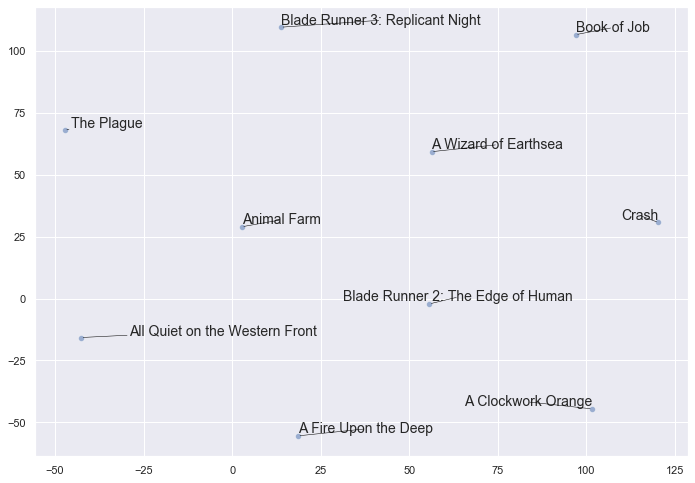

In [49]:
from sklearn.manifold import TSNE
from adjustText import adjust_text
import seaborn as sns
import matplotlib.pyplot as plt
book_titles = new_file['book name']
titles_list = [title for title in book_titles]
titles_list = titles_list[:10]
def t_SNE_plot(df_data):
    # Initialize t-SNE
    tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

    # Use only 400 rows to shorten processing time
    tsne_df = tsne.fit_transform(df_data)#tsne.fit_transform(df_data[:400])

    sns.set()
    # Initialize figure
    fig, ax = plt.subplots(figsize = (11.7, 8.27))
    sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

    # Import adjustText, initialize list of texts

    texts = []
    data_to_plot = list(np.arange(0, 10, 1))#list(np.arange(0, 400, 40))

    # Append words to list
    for data in data_to_plot:
        texts.append(plt.text(tsne_df[data, 0], tsne_df[data, 1], titles_list[data], fontsize = 14))

    # Plot text using adjust_text (because overlapping text is hard to read)
    adjust_text(texts, force_points = 0.4, force_text = 0.4, 
                expand_points = (2,1), expand_text = (1,2),
                arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

    plt.show()

t_SNE_plot(summary_vec[:10])    

## Padding sequences

In [50]:
max_Length = 0  
for x in all_words_index:
    if len(x) > max_Length:
        max_Length = len(x)
max_Length

4250

In [58]:
def pad_sequences(all_words_index, seq_length):
    
    # getting the correct rows x cols shape
    sequences = np.zeros((len(all_words_index), seq_length), dtype=int)
 
    # for each review, I grab that review and 
    for i, row in enumerate(all_words_index):
        if len(row)>0:
            sequences[i, -len(row):] =  np.array(row)[:seq_length]
    
    return sequences

In [61]:
sequences = pad_sequences(all_words_index, max_Length)

assert len(sequences)==len(all_words_index), "Sequences should have as many rows as reviews."
assert len(sequences[0])==max_Length, "Each sequence row should contain seq_length values."

print(sequences[2])

[    0     0     0 ... 32149 18808 17561]


# Training, Validation, and Test Data

In [62]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(sequences)*split_frac)
train_x, remaining_x = sequences[:split_idx], sequences[split_idx:]
train_y, remaining_y = one_hot[:split_idx], one_hot[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tSequences Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))


			Sequences Shapes:
Train set: 		(10272, 4250) 
Validation set: 	(1284, 4250) 
Test set: 		(1285, 4250)


### Above only 2,0,1 because I only used  3 datasample to do all of these

# DataLoaders and Batching

In [63]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(np.array(train_x)), torch.from_numpy(np.array(train_y)[:,0]))
valid_data = TensorDataset(torch.from_numpy(np.array(val_x)), torch.from_numpy(np.array(val_y)))
test_data = TensorDataset(torch.from_numpy(np.array(test_x)), torch.from_numpy(np.array(test_y)))

# dataloaders
batch_size = 64
#RANDOM_SEED = 1


# shuffling and batching data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=4)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, num_workers=4)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, num_workers=4)

# LSTM model

In [108]:

import torch as t
import numpy as np
from torch import nn
import torch.nn.functional as F


# def kmax_pooling(x, dim, k):
#     index = x.topk(k, dim = dim)[1].sort(dim = dim)[0]
#     return x.gather(dim, index)

class LSTMText(torch.nn.Module): 
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers, 
                linear_hidden_size, num_classes, freeze_embeddings=True):
        super(LSTMText, self).__init__()
        
        self.num_classes = num_classes
        # 1. embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # set weights to pre-trained
        self.embedding.weight = nn.Parameter(torch.from_numpy(word_vec_array)) # all vectors
        # (optional) freeze embedding weights
        if freeze_embeddings:
            self.embedding.requires_grad = False

        self.lstm =nn.LSTM( input_size = embedding_dim,
                            hidden_size = hidden_size,
                            num_layers = num_layers,
                            bias = True,
                            batch_first = False,
                            # dropout = 0.5,
                            bidirectional = True
                            )

        # self.dropout = nn.Dropout()
        self.fc = nn.Sequential(
            nn.Linear(hidden_size*2, linear_hidden_size),
            nn.BatchNorm1d(linear_hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(linear_hidden_size, num_classes)
        )
        
         #activation function
        self.act = nn.Sigmoid()
 
    def forward(self, text):
      
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
        
        #packed sequence
        #packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True)
        
        #packed_output, (hidden, cell) = self.lstm(packed_embedded)
        packed_output = self.lstm(embedded.double().permute(1,0,2))[0].permute(1,2,0)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        #concat the final forward and backward hidden state
        #hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        #logits=self.fc(hidden)
        logits=self.fc(packed_output)

        #Final activation function
        probas=self.act(logits, dim = 1)

        return logits, probas


# Instantiate the network

In [109]:
# vocab_size, embedding_dim, hidden_size, num_layers, 
#                  bidirectional, dropout, linear_hidden_size, num_classes
    
# Instantiate the model with hyperparameters
import random
vocab_size = word_vec.shape[0]#len(google_vecs.vocab)
#num_classes = 1 # binary class (1 or 0)
embedding_dim = google_vecs.vector_size # 300-dim vectors
hidden_size = 256 #LSTM hidden size
num_layers=2 #LSTM layers
linear_hidden_size = 200 # units number of full connected 
num_classes = len(label_list)

random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)  ###revise

model = LSTMText(vocab_size, embedding_dim, hidden_size, num_layers, 
                 linear_hidden_size, num_classes)

print(model)
model = model.to(DEVICE)

#No. of trianable parameters
def count_parameters(model):
    return sum(m.numel() for m in model.parameters() if m.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')


LSTMText(
  (embedding): Embedding(51249, 300)
  (lstm): LSTM(300, 256, num_layers=2, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=2000, bias=True)
    (1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=2000, out_features=227, bias=True)
  )
  (act): Sigmoid()
)
The model has 19,578,671 trainable parameters


In [110]:
NUM_EPOCHS = 2
GRAYSCALE = False
intial_lr = 0.1
        
optimizer = torch.optim.Adam(model.parameters(), lr=intial_lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=0.1,
                                                   last_epoch=-1)


# Define loss function and evaluation parameters and Train

In [111]:
def compute_accuracy_and_loss(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    cross_entropy = 0.
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        loss += F.BCELoss(logits, targets).item()
        predicted_labels = torch.from_numpy((probas > 0.5).astype(np.uint8))
        num_examples += targets.size(0)
        
    average_loss = loss/ num_examples
    accuracy = accuracy_score(targets, predicted_labels)
    ACU = roc_auc_score(targets, predicted_labels)
    f_measure = precision_recall_fscore_support(targets, predicted_labels,average='weighted')
    return average_loss, accuracy, ACU, f_measure
    

start_time = time.time()
train_acc_lst, valid_acc_lst = [], []
train_loss_lst, valid_loss_lst = [], []

for epoch in range(NUM_EPOCHS):
    
    model.train()
    
    for batch_idx, (features, targets) in enumerate(train_loader): #, 
        print(batch)
        print(len(batch))
        ### PREPARE MINIBATCH
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
#         features, features_lengths = batch.features
#         targets = batch.targets
#         print(features_lengths)
        #retrieve text and no. of words
        
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features.long())
        cost = F.BCELoss(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 20:
            print (f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} | '
                   f'Batch {batch_idx:03d}/{len(train_loader):03d} |' 
                   f' Cost: {cost:.4f}')
        if not epoch % 10:
            scheduler.step()
        
    # no need to build the computation graph for backprop when computing accuracy
    model.eval()
    with torch.set_grad_enabled(False):
        train_acc, train_loss, train_ACU, train_f_measure = compute_accuracy_and_loss(model, train_loader, device=DEVICE)
        valid_acc, valid_loss, valid_ACU, valid_f_measure = compute_accuracy_and_loss(model, valid_loader, device=DEVICE)
        train_acc_lst.append(train_acc)
        valid_acc_lst.append(valid_acc)
        train_loss_lst.append(train_loss)
        valid_loss_lst.append(valid_loss)
        print(f'Epoch: {epoch+1:03d}/{NUM_EPOCHS:03d} Train Acc.: {train_acc:.2f}%'
              f' | Validation Acc.: {valid_acc:.2f}%')

    elapsed = (time.time() - start_time)/60
    print(f'Time elapsed: {elapsed:.2f} min')
  
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')

[tensor([[    0,     0,     0,  ..., 15854, 29663, 12017],
        [    0,     0,     0,  ..., 16057, 36421, 47708],
        [    0,     0,     0,  ..., 24908, 30613, 26114],
        ...,
        [    0,     0,     0,  ..., 11897,  1631, 42428],
        [    0,     0,     0,  ..., 35038, 12937, 20883],
        [    0,     0,     0,  ..., 27981, 28771, 43824]]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]
2


RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #2 'mat2' in call to _th_mm

In [ ]:
plt.plot(range(1, NUM_EPOCHS+1), train_loss_lst, label='Training loss')
plt.plot(range(1, NUM_EPOCHS+1), valid_loss_lst, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel('Cross entropy')
plt.xlabel('Epoch')
plt.show()

In [ ]:
plt.plot(range(1, NUM_EPOCHS+1), train_acc_lst, label='Training accuracy')
plt.plot(range(1, NUM_EPOCHS+1), valid_acc_lst, label='Validation accuracy')
plt.legend(loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.show()
print(f'Training accuracy: {train_acc_lst[-1]:.2f}%')
print(f'Validation accuracy: {valid_acc_lst[-1]:.2f}%')

In [ ]:
model.eval()
with torch.set_grad_enabled(False): # save memory during inference
    test_acc, test_loss = compute_accuracy_and_loss(model, test_loader, DEVICE)
    print(f'Test accuracy: {test_acc:.2f}%')